In [92]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization, memory_task_evolution, ragged_task_evolution, ragged_general_network

In [93]:
data_dir = os.path.join(os.getenv("HOME"), "boolean_network_data/memory_evolution_results/2023-02-13-20-21-52")
with open(os.path.join(data_dir,"best_populations.pk"), "rb") as f:
    populations = pickle.load(f)


In [94]:
N = populations[0][0].shape[0]
input_state = cp.asnumpy(memory_task_evolution.make_memory_input_state(N))
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (2, len(populations), 1, N)).astype(np.bool_)
best_functions = np.expand_dims(np.stack([x[0] for x in populations], axis=0), 1).astype(np.bool_)
best_conn = np.expand_dims(np.stack([x[1] for x in populations], axis=0), 1).astype(np.int16)
best_used_conn = np.expand_dims(np.stack([x[2] for x in populations], axis=0), 1).astype(np.bool_)

In [113]:
best_errors = np.squeeze(ragged_task_evolution.evaluate_populations(batched_input_state, 20000, best_functions, best_conn, best_used_conn, 11, 0.01, memory_task_evolution.evaluate_memory_task), -1)

In [114]:
perf_idx = np.argsort(best_errors)
populations = [populations[x] for x in perf_idx]
sorted_perfs = best_errors[perf_idx]
best_functions = np.expand_dims(np.stack([x[0] for x in populations], axis=0), 1).astype(np.bool_)
best_conn = np.expand_dims(np.stack([x[1] for x in populations], axis=0), 1).astype(np.int16)
best_used_conn = np.expand_dims(np.stack([x[2] for x in populations], axis=0), 1).astype(np.bool_)

In [115]:
graphs = [general_network_visualization.graph_from_ragged_spec(x[1], x[2]) for x in populations]

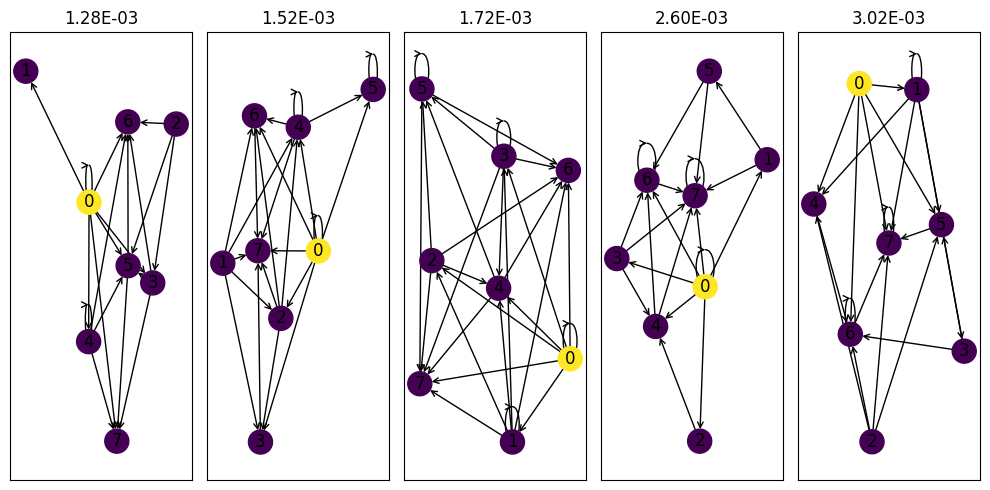

In [116]:
best_to_plot = 5
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(10,5))
node_colors = np.zeros(N)
node_colors[0] = 1

for g, ax, err in zip(graphs, axs, sorted_perfs[:best_to_plot]):
    labels = {}
    for node in g.nodes():
        labels[node]=node
    pos = nx.spring_layout(g, iterations=1000)
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color=node_colors)
    nx.draw_networkx_edges(g, pos=pos, arrowstyle="->", ax=ax, arrows=True)
    nx.draw_networkx_labels(g, pos, labels, ax=ax)
    ax.set_title("{:.2E}".format(err))
fig.tight_layout()

In [117]:
def run_dynamics_forward_save_state(input_state, functions, connections, used_connections, n_timesteps, p_noise):
    xp = np
    if isinstance(input_state, cp.ndarray):
        xp = cp
    states = np.tile(np.expand_dims(input_state, 0), (n_timesteps + 2, *([1] * len(input_state.shape))))
    noise = xp.random.binomial(1, p_noise, (n_timesteps, *input_state.shape)).astype(np.bool_)
    for i in range(n_timesteps):
        states[i+1] = np.bitwise_xor(ragged_general_network.ragged_k_state_update(states[i], functions, connections, used_connections), noise[i])
    states[-1] = ragged_general_network.ragged_k_state_update(states[-2], functions, connections, used_connections)
    return states, noise

In [118]:
example_trajs, example_noise = run_dynamics_forward_save_state(batched_input_state, best_functions, best_conn, best_used_conn, 20, 0.01)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

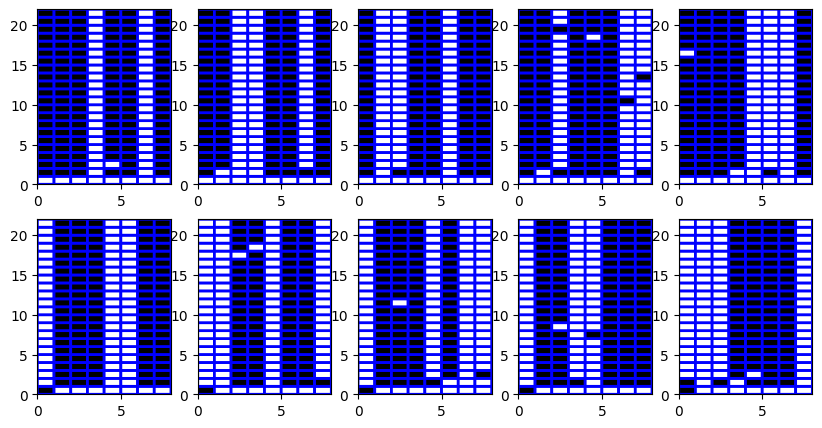

In [119]:
fig, axs = plt.subplots(nrows=2, ncols=best_to_plot, figsize=(10, 5))
for i in range(best_to_plot):
    axs[0, i].pcolor(example_trajs[:, 0, i, :], cmap="Greys", linewidth=2, edgecolors="blue")
    axs[1, i].pcolor(example_trajs[:, 1, i, :], cmap="Greys", linewidth=2, edgecolors="blue")


In [120]:
physical_error_rates = np.linspace(start=0, stop=0.03, num=20)
logical_error_rates = []
for error_rate in physical_error_rates:
    logical_error_rates.append(np.squeeze(ragged_task_evolution.evaluate_populations(batched_input_state, 5000, best_functions, best_conn, best_used_conn, 11, error_rate, memory_task_evolution.evaluate_memory_task), -1))


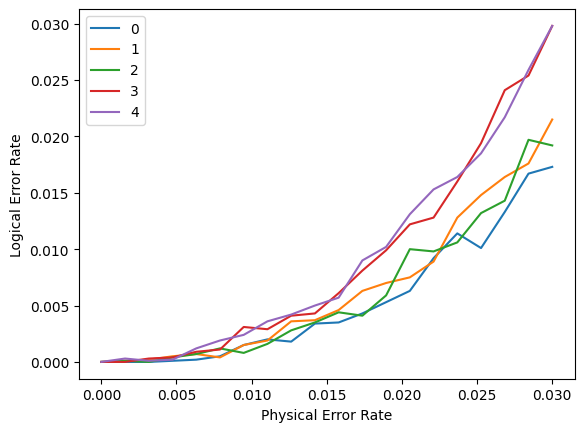

In [121]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()


In [ ]:
def death_prob_vs_time():

